# Персептрон на NumPy

**Объектно‑ориентированный подход** к реализации персептрона, который позволяет:

1. **Инициализировать** новые объекты `Perceptron` с параметрами:
   - `eta` — скорость обучения (0.0–1.0)
   - `n_iter` — число проходов по данным
2. **Обучать** модель методом `fit(X, y)`  
   > При старте:  
   > - Вектор весов `self.w_` инициализируется случайно:  
   >   $$\mathbf{w} \sim \mathcal{N}(0,\,0.01)$$  
   > - Смещение `self.b_ = 0`
3. **Прогнозировать** с помощью `predict(X_new)`, где  
   $$\text{predict}(X) = 
   \begin{cases}
     1, & \mathbf{w}^\top X + b \ge 0\\
     0, & \text{иначе}
   \end{cases}$$

---


Применив данную реализацию персептрона, можно инициализировать новые объекты с заданной скоростью `eta` и кол-вом эпох `n_iter`.
С помощью метода` fit()` мы инициализируем смещение `self.b_` начальным значением 0, а веса `self.w_` - вектором, где начальный вектор весов содержит небольшие случайные числа, взятые из нормального распределения со стандартным отклонением 0.01, где rgen - генератор случайных чисел **NumPy**.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd

In [2]:
class Perceptron:
    """Персептронный классификатор
    
    Параметры
    ----------
    eta : float  # Скорость обучения (между 0.0 и 1.0)
    n_iter : int  # Кол-во проходов по обучающему набору
    random_state : int  # Опорное значение генератора случайных чисел для инициализации весов

    Атрибуты
    ---------
    w_ : 1d-array # Веса после подгонки
    b_ : Scalar # Смещение после подгонки
    errors_: list # Кол-во неправильных классификаций (обновлений) в каждой эпохе
    """

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Соответствие тренировочным данным

        Параметры
        ----------
        X : {array-like}, shape = [n_examples, n_features] # Обучающий вектор, где n_examples - кол-во образцов, а  n_feature - кол-во признаков
        y : array-like, shape = [n_examples] # Целевые значения

        self : object # Возвращаемые значения
        """

        rgen = np.random.RandomState(self.random_state)
        self.errors_ = []
        self.w_ = rgen.normal(loc = 0.0, scale = 0.01, size = X.shape[1])
        self.b_ = np.float64(0.0)

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update 
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Вычисление фактического входа"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Возвращаем метки класса после шага"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)    

In [3]:
# Загружаем данные
iris = datasets.load_iris()

# Используем все признаки (все 4 колонки) и первые 5 строк
X_all = iris.data[:5]
y_all = iris.target[:5]

# Преобразуем метки (0, 1, 2) в названия видов
target_names = iris.target_names
flower_names = [target_names[i] for i in y_all]

# Формируем DataFrame
df = pd.DataFrame(X_all, columns=iris.feature_names)
df['species'] = flower_names

print(df)


# Данные Iris: первые 100 образцов (два класса), фичи = sepal length, petal length
iris = datasets.load_iris()
X = iris.data[:100, [0, 2]]
y = iris.target[:100]

# Создаем и обучаем персептрон
ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(X, y)

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  


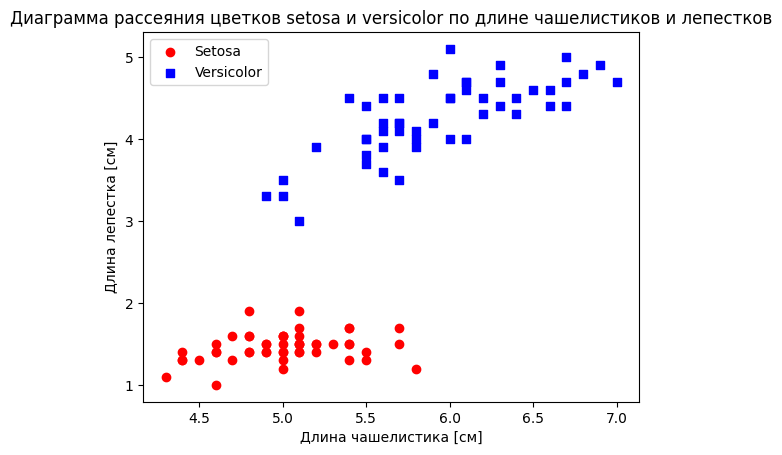

In [4]:
# 1) График области принятия решений
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='Setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='s', label='Versicolor')
plt.xlabel('Длина чашелистика [см]')
plt.ylabel('Длина лепестка [см]')
plt.title('Диаграмма рассеяния цветков setosa и versicolor по длине чашелистиков и лепестков')
plt.legend(loc='upper left')
plt.show()

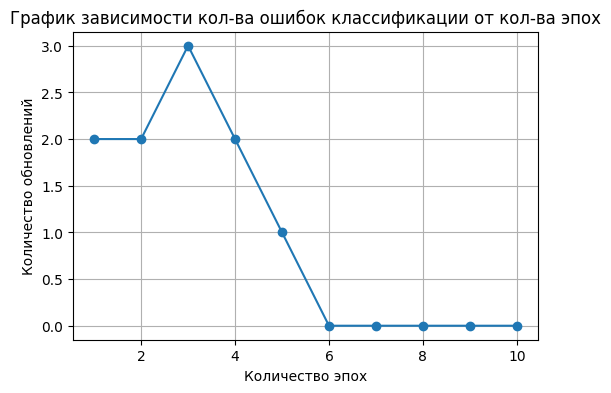

In [5]:
# 2) График ошибок по эпохам
plt.figure(figsize=(6, 4))

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Количество эпох')
plt.ylabel('Количество обновлений')
plt.title('График зависимости кол-ва ошибок классификации от кол-ва эпох')
plt.grid(True)
plt.show()

Как показано на графике, персептрон сошелся после шестой эпохи и теперь должен идеально классифицировать обучающие примеры. Далее мы построим функцию визуализации решающих границ для двумерных наборов данных. 

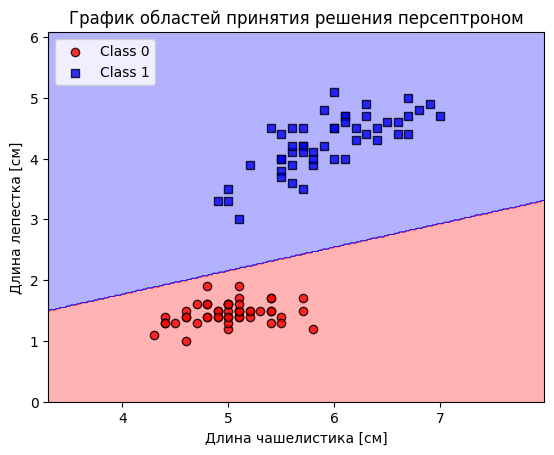

In [6]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # Настройка генератора меток и цветной карты
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # Построение решающей поверхности
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha = 0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Построение образцов класса
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                   y = X[y == cl, 1],
                   alpha=0.8,
                   c=colors[idx],
                   marker=markers[idx],
                   label=f'Class {cl}',
                   edgecolor='black')

plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('Длина чашелистика [см]')
plt.ylabel('Длина лепестка [см]')
plt.title('График областей принятия решения персептроном')
plt.legend(loc='upper left')
plt.show()

Как видно на графике, персептрон нашёл разделяющую границу, которая может идеально классифицировать все примеры цветков в обучающем подиножестве Iris.
Хоть и персептрон идеально классифицировал два класса цветков, сходимость - одна из самых больших проблем персептрона. Правило обучения персептрона сходится, если два класса можно разделить линейной гиперплоскостью. Однако, если классы не могут быть идеально разделены такой линейной границей, веса никогда не перестанут обновляться, если мы не установим максимальное кол-во эпох.